In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import randint
# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
#Neural Network
from sklearn.model_selection import RandomizedSearchCV
#Bagging
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data = pd.read_csv("/content/survey.csv",index_col="E.Code")

In [3]:
#missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

                    Total   Percent
work_interfere        262  0.209768
Date                    0  0.000000
Age                     0  0.000000
Gender                  0  0.000000
family_history          0  0.000000
treatment               0  0.000000
remote_work             0  0.000000
benefits                0  0.000000
wellness_program        0  0.000000
anonymity               0  0.000000
leave                   0  0.000000
mental_vs_physical      0  0.000000


In [4]:
defaultString = 'NaN'
data['work_interfere'] = data['work_interfere'].replace([defaultString], 'Don\'t know' )
print(data['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' nan]


In [5]:
#Encoding data
labelDict = {}
for feature in data:
    le = preprocessing.LabelEncoder()
    le.fit(data[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    data[feature] = le.transform(data[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue

In [6]:
#testing for any missing value
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

                    Total  Percent
Date                    0      0.0
Age                     0      0.0
Gender                  0      0.0
family_history          0      0.0
treatment               0      0.0
work_interfere          0      0.0
remote_work             0      0.0
benefits                0      0.0
wellness_program        0      0.0
anonymity               0      0.0
leave                   0      0.0
mental_vs_physical      0      0.0


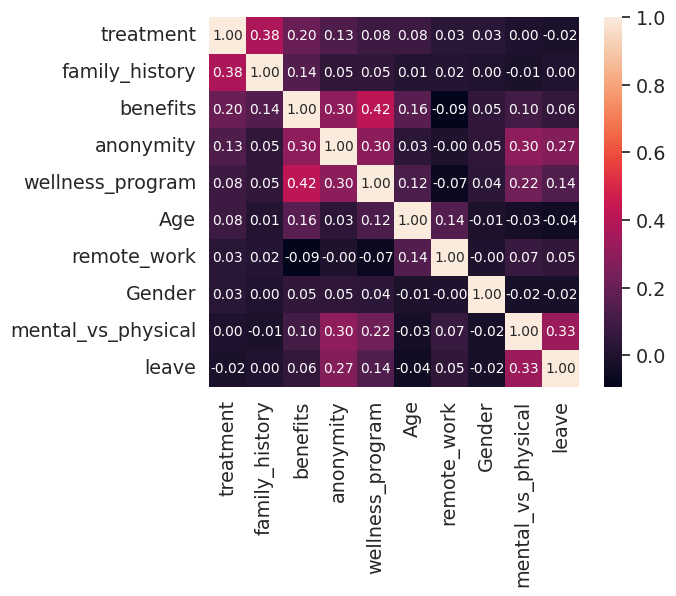

In [7]:
corrmat = data.corr()
#treatment correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [8]:
# define X and y
feature_cols = ['Age', 'Gender', 'family_history', 'benefits',  'anonymity', 'leave', 'work_interfere']
X = data[feature_cols]
y = data.treatment
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()

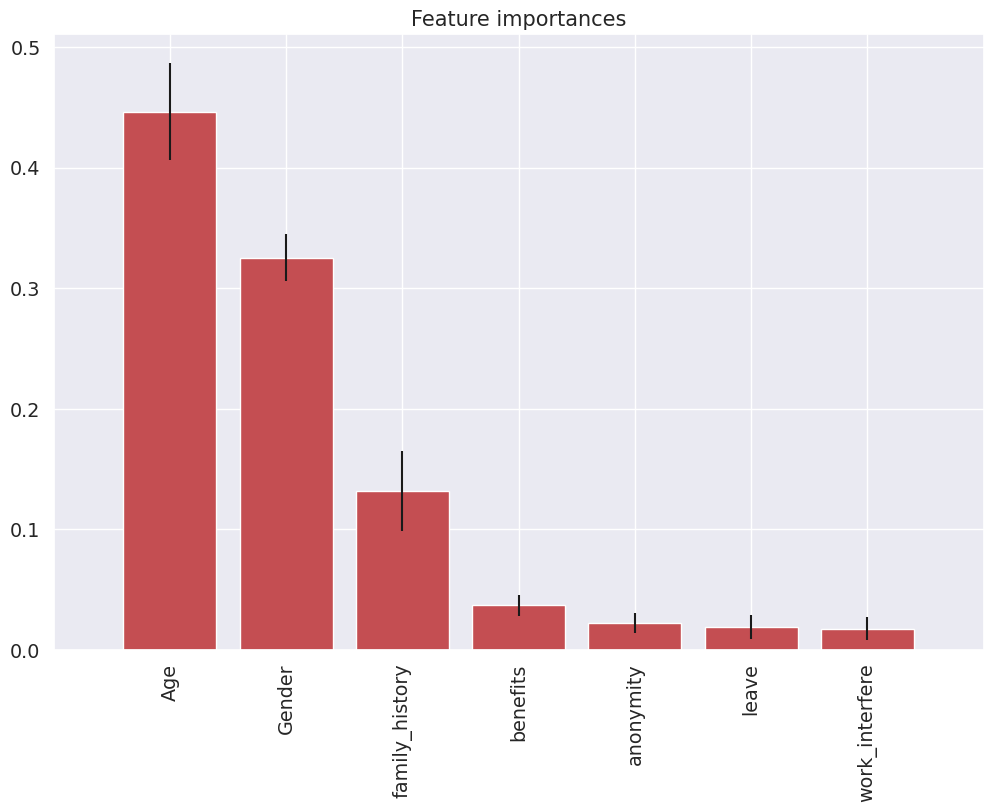

In [9]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])

# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

In [10]:
def evalClassModel(model, y_test, y_pred_class, plot=False):
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    return accuracy

In [11]:
def tuningCV(knn):
    # search for an optimal value of K for KNN
    k_range = list(range(1, 31))
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
        k_scores.append(scores.mean())

In [12]:
def tuningGridSerach(knn):
    k_range = list(range(1, 31))
    # create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range)
    # instantiate the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
    # fit the grid with data
    grid.fit(X, y)
    # create a list of the mean scores only
    grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]

In [13]:
def tuningRandomizedSearchCV(model, param_dist):
    #Searching multiple parameters simultaneously
    # n_iter controls the number of searches
    rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
    rand.fit(X, y)
    # Accessing the results
    results = rand.cv_results_
    # run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
    best_scores = []
    for _ in range(20):
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10)
        rand.fit(X, y)
        best_scores.append(round(rand.best_score_, 3))

In [14]:
def tuningMultParam(knn):
    #Searching multiple parameters simultaneously
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']

    # create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range, weights=weight_options)

    # instantiate and fit the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
    grid.fit(X, y)

In [15]:
from sklearnex import patch_sklearn
patch_sklearn()
def logisticRegression():
    # train a logistic regression model on the training set
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)

    # make class predictions for the testing set
    y_pred_class = logreg.predict(X_test)

    print('########### Logistic Regression ###############')

    accuracy_score = evalClassModel(logreg, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Log. Regres.'] = accuracy_score * 100
    print(accuracy_score * 100)
logisticRegression()

########### Logistic Regression ###############
Accuracy: 0.7013333333333334
70.13333333333334


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [16]:
from sklearnex import patch_sklearn
patch_sklearn()
def treeClassifier():
    # Calculating the best parameters
    tree = DecisionTreeClassifier()
    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(tree, param_dist)

    # train a decision tree model on the training set
    tree = DecisionTreeClassifier(max_depth=3, min_samples_split=8, max_features=6, criterion='entropy', min_samples_leaf=7)
    tree.fit(X_train, y_train)

    # make class predictions for the testing set
    y_pred_class = tree.predict(X_test)

    print('########### Tree classifier ###############')

    accuracy_score = evalClassModel(tree, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Tree clas.'] = accuracy_score * 100
treeClassifier()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


########### Tree classifier ###############
Accuracy: 0.8186666666666667


In [17]:
from sklearnex import patch_sklearn
patch_sklearn()
def randomForest():
    # Calculating the best parameters
    forest = RandomForestClassifier(n_estimators = 20)

    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(forest, param_dist)

    # Building and fitting my_forest
    forest = RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 20, random_state = 1)
    my_forest = forest.fit(X_train, y_train)

    # make class predictions for the testing set
    y_pred_class = my_forest.predict(X_test)

    print('########### Random Forests ###############')

    accuracy_score = evalClassModel(my_forest, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['R. Forest'] = accuracy_score * 100
randomForest()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


########### Random Forests ###############
Accuracy: 0.832


In [18]:
from sklearnex import patch_sklearn
patch_sklearn()
def boosting():
    # Building and fitting
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    boost = AdaBoostClassifier(estimator=clf, n_estimators=500)
    boost.fit(X_train, y_train)

    # make class predictions for the testing set
    y_pred_class = boost.predict(X_test)

    print('########### Boosting ###############')

    accuracy_score = evalClassModel(boost, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Boosting'] = accuracy_score * 100
boosting()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


########### Boosting ###############
Accuracy: 0.816


In [19]:
import tensorflow as tf
import argparse
batch_size = 100
train_steps = 1000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
def train_input_fn(features, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    return dataset.shuffle(1000).repeat().batch(batch_size)
def eval_input_fn(features, labels, batch_size):
    features=dict(features)
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)
    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)
    return dataset

In [20]:
# Define Tensorflow feature columns
age = tf.feature_column.numeric_column("Age")
gender = tf.feature_column.numeric_column("Gender")
family_history = tf.feature_column.numeric_column("family_history")
benefits = tf.feature_column.numeric_column("benefits")
anonymity = tf.feature_column.numeric_column("anonymity")
leave = tf.feature_column.numeric_column("leave")
work_interfere = tf.feature_column.numeric_column("work_interfere")
feature_columns = [age, gender, family_history, benefits, anonymity, leave, work_interfere]

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [21]:
# Build a DNN with 2 hidden layers and 10 nodes in each hidden layer.
model = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[10, 10],
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
)

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


In [22]:
model.train(input_fn=lambda:train_input_fn(X_train, y_train, batch_size), steps=train_steps)

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


In [23]:
# Evaluate the model.
eval_result = model.evaluate(
    input_fn=lambda:eval_input_fn(X_test, y_test, batch_size))
print('\nTest set accuracy: {accuracy:0.2f}\n'.format(**eval_result))

Instructions for updating:
Use tf.keras instead.



Test set accuracy: 0.82



In [24]:
predictions = list(model.predict(input_fn=lambda:eval_input_fn(X_train, y_train, batch_size=batch_size)))

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


In [25]:
# Generate predictions from the model
template = ('\nEmp Id: "{}", Prediction is "{}" ({:.1f}%), expected "{}"')
col1 = []
col2 = []
col3 = []
for idx, input, p in zip(X_train.index, y_train, predictions):
    v  = p["class_ids"][0]
    class_id = p['class_ids'][0]
    probability = p['probabilities'][class_id]
    col1.append(idx)
    col2.append(v)
    col3.append(input)
results = pd.DataFrame({'E.Code':col1, 'prediction':col2, 'expected':col3})
results.head()

,E.Code,prediction,expected
0,201,1,1
1,1116,1,0
2,66,1,0
3,413,0,0
4,1209,1,0


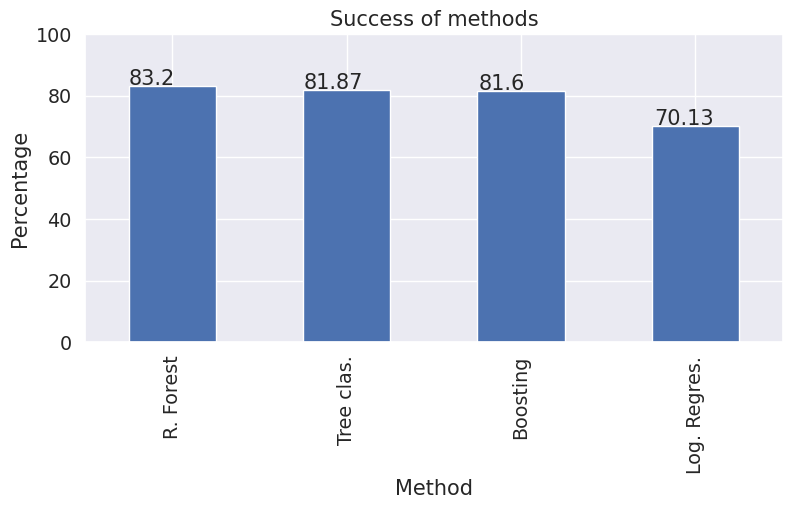

In [26]:
def plotSuccess():
    s = pd.Series(methodDict)
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(9,4))
    #Colors
    ax = s.plot(kind='bar')
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([00.0, 100.0])
    plt.xlabel('Method')
    plt.ylabel('Percentage')
    plt.title('Success of methods')

    plt.show()
plotSuccess()

In [27]:
# Generate predictions with the best method
clf = RandomForestClassifier()
clf.fit(X, y)
dfTestPredictions = clf.predict(X_test)

# Write predictions to csv file
# We don't have any significative field so we save the index
results = pd.DataFrame({'Emp Id': X_test.index, 'Treatment': dfTestPredictions})
# Save to file
# This file will be visible after publishing in the output section
results.to_csv('mentalheath.csv', index=False)
results.head()

,Emp Id,Treatment
0,712,0
1,847,1
2,187,0
3,867,1
4,19,0


In [28]:
!python app.py

 * Serving Flask app 'app'
 * Debug mode: on
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 727-697-391
